# Aggregate all of the Previous DataSets

In [1]:
import pandas as pd
import numpy as np
import plotnine as p9
from plotnine import ggplot, aes, facet_grid, labs, geom_point, geom_smooth, coord_flip, scale_color_manual
from sklearn.linear_model import LinearRegression as lm
import statsmodels.tools.tools as sm
from statsmodels.discrete.discrete_model import Probit
from statsmodels.discrete.discrete_model import Logit
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_rows", None, "display.max_columns", None)

Pull together all of the datasets cleaned

In [2]:
#awaiting Cook release of 2002 datapoints
#df108 = pd.read_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/full_districts/data_108.csv")
df109 = pd.read_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/full_districts/data_109.csv")
df110 = pd.read_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/full_districts/data_110.csv")
df111 = pd.read_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/full_districts/data_111.csv")
df112 = pd.read_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/full_districts/data_112.csv")
df113 = pd.read_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/full_districts/data_113.csv")
df114 = pd.read_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/full_districts/data_114.csv")
df115 = pd.read_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/full_districts/data_115.csv")
df116 = pd.read_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/full_districts/data_116.csv")
df117 = pd.read_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/full_districts/data_117.csv")

Concatonate and Touch Up

In [3]:
df = pd.concat([df109,df110,df111,df112,df113,df114,df115,df116,df117])
df["PVI"] = df["PVI"].str.replace("D+0","R+0")

Put into CSV for Later Use

In [4]:
df.to_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/processed/aggregated_districts.csv", index = False)

In [5]:
#create pre-binned version for posterity
binned = df
binned["bin"] = pd.cut(binned['metric'], 
    bins = [0, .24, .42, .44, .45, .46, .47, .48, .49, .5,
    .51, .52, .53, .54, .57, .7, 1], labels =
    ["D+26+","D+25 to D+8","D+7 to D+6","D+5","D+4","D+3","D+2","D+1",
    "EVEN","R+1","R+2","R+3","R+4","R+5 to R+7","R+8 to R+20","R+21+"])
binned = binned.sort_values(by="metric")

In [6]:
#group by metric and average GOP seats
bm = df.groupby('metric').mean()
#this will not be produced into a dataset without aggregating all years, as 
bm = bm.sort_values('metric')
bm = bm.reset_index()

In [7]:
#create a dataset where the metric is between 10% and 90% Republican
df_gop = df[df["metric"] > .5]
df_gop = df_gop[df_gop["metric"] <= .71]
df_dem = df[df["metric"] <= .5]
#df_dem = df_dem[df_dem["metric"] >= .38]

# Begin Split Probit

## Dem Probit

In [8]:
#group by metric and average GOP seats
bm_dem = df_dem.groupby('metric').mean()
#this will not be produced into a dataset without aggregating all years, as 
bm_dem = bm_dem.sort_values('metric')
bm_dem = bm_dem.reset_index()

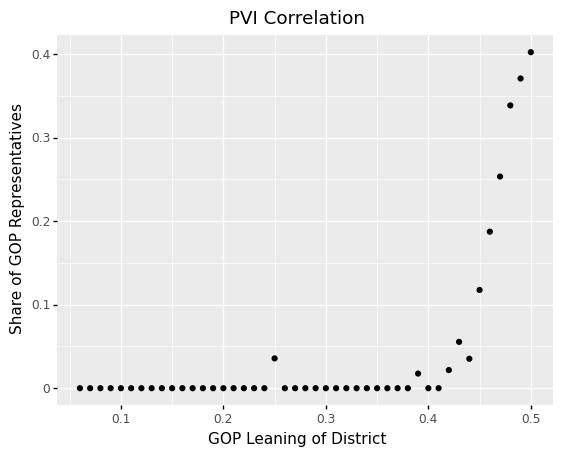

<ggplot: (8794010785018)>

In [9]:
#Plot averages
(p9.ggplot(data=bm_dem, mapping=p9.aes(x='metric', y='is_GOP'))
 + p9.geom_point() 
 + labs(x='GOP Leaning of District', y="Share of GOP Representatives",color="",title="PVI Correlation"))

In [10]:
#set input of GOP to a probit friendly format
df_dem.is_GOP = df_dem.is_GOP == 1
#define variables
Y = df_dem.is_GOP
X = df_dem.metric
model = Probit(Y, sm.add_constant(X).astype(float))
prob_mod = model.fit()
pred_Y = prob_mod.predict(sm.add_constant(X))
prob_mod.summary()

Optimization terminated successfully.
         Current function value: 0.168019
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:                 is_GOP   No. Observations:                 1806
Model:                         Probit   Df Residuals:                     1804
Method:                           MLE   Df Model:                            1
Date:                Sat, 12 Mar 2022   Pseudo R-squ.:                  0.3434
Time:                        13:57:41   Log-Likelihood:                -303.44
converged:                       True   LL-Null:                       -462.15
Covariance Type:            nonrobust   LLR p-value:                 5.307e-71
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.8132      0.776    -12.645      0.000     -11.334      -8.292
metric        19.1871      1.679     11.429      0.000      15.897      22.478
==============================================================================

Possibly complete quasi-separation: A fraction 0.31 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

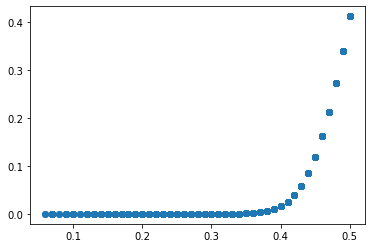

In [11]:
plt.scatter(X,pred_Y)

In [12]:
results = pd.concat([X,pred_Y], axis = 1)
#group by metric and average GOP seats
bm_dem_probit = results.groupby('metric').mean()
#this will not be produced into a dataset without aggregating all years, as 
bm_dem_probit = bm_dem_probit.sort_values('metric')
bm_dem_probit = bm_dem_probit.reset_index()
bm_dem_probit[0] = bm_dem_probit[0].round(2)

In [13]:
bm_dem_probit

,metric,0
0,0.06,0.00
1,0.07,0.00
2,0.08,0.00
3,0.09,0.00
4,0.10,0.00
5,0.11,0.00
6,0.12,0.00
7,0.13,0.00
8,0.14,0.00
9,0.15,0.00


## GOP Probit

In [14]:
#group by metric and average GOP seats
bm_gop = df_gop.groupby('metric').mean()
#this will not be produced into a dataset without aggregating all years, as 
bm_gop = bm_gop.sort_values('metric')
bm_gop = bm_gop.reset_index()

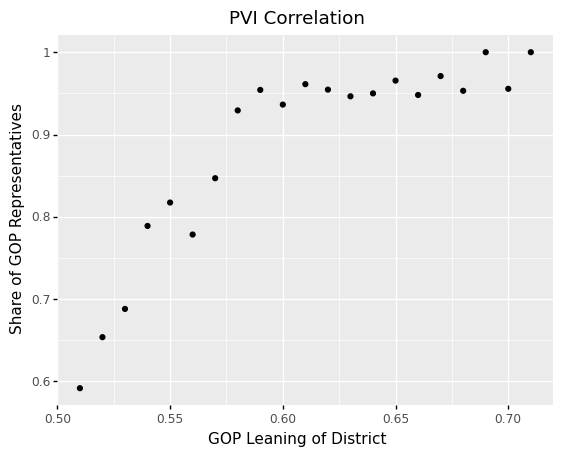

<ggplot: (8794010792268)>

In [15]:
#Plot averages
(p9.ggplot(data=bm_gop, mapping=p9.aes(x='metric', y='is_GOP'))
 + p9.geom_point() 
 + labs(x='GOP Leaning of District', y="Share of GOP Representatives",color="",title="PVI Correlation"))

In [16]:
#set input of GOP to a probit friendly format
df_gop.is_GOP = df_gop.is_GOP == 1
#define variables
Y = df_gop.is_GOP
X = df_gop.metric
model = Probit(Y, sm.add_constant(X).astype(float))
prob_mod = model.fit()
pred_Y = prob_mod.predict(sm.add_constant(X))
prob_mod.summary()

Optimization terminated successfully.
         Current function value: 0.334309
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:                 is_GOP   No. Observations:                 1938
Model:                         Probit   Df Residuals:                     1936
Method:                           MLE   Df Model:                            1
Date:                Sat, 12 Mar 2022   Pseudo R-squ.:                  0.1305
Time:                        13:57:42   Log-Likelihood:                -647.89
converged:                       True   LL-Null:                       -745.12
Covariance Type:            nonrobust   LLR p-value:                 3.382e-44
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.0595      0.487    -10.390      0.000      -6.014      -4.105
metric        10.6757      0.852     12.534      0.000       9.006      12.345
==============================================================================
"""

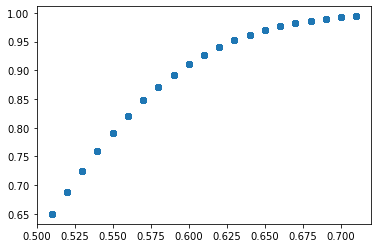

In [17]:
plt.scatter(X,pred_Y)

In [18]:
results = pd.concat([X,pred_Y], axis = 1)
#group by metric and average GOP seats
bm_gop_probit = results.groupby('metric').mean()
#this will not be produced into a dataset without aggregating all years, as 
bm_gop_probit = bm_gop_probit.sort_values('metric')
bm_gop_probit = bm_gop_probit.reset_index()
bm_gop_probit[0] = bm_gop_probit[0].round(2)

# Conduct a split model with custom fits

Parameters [ 3.57883333e+01  5.04924727e-01 -2.22657500e-03]
RMSE: 0.01699842782374501
R-squared: 0.9716716698620923


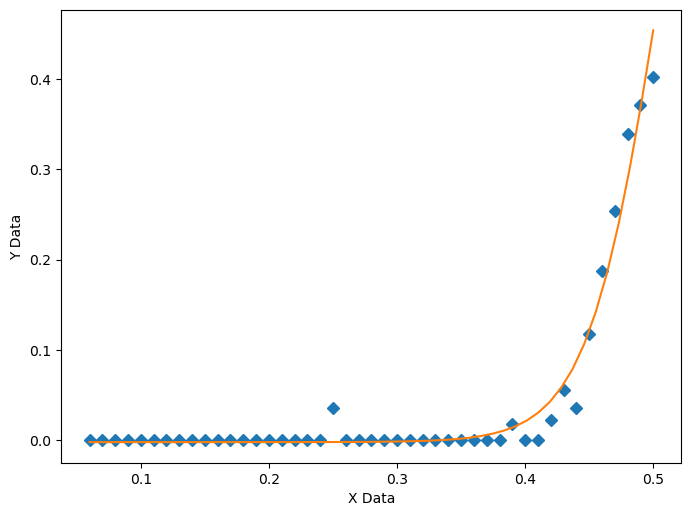

In [19]:
xdem = bm_dem.metric
ydem = bm_dem.is_GOP

def func(x, a, b, Offset): # Sigmoid A With Offset from zunzun.com
    return  1.0 / (1.0 + np.exp(-a * (x-b))) + Offset


# function for genetic algorithm to minimize (sum of squared error)
def sumOfSquaredError(parameterTuple):
    warnings.filterwarnings("ignore") # do not print warnings by genetic algorithm
    val = func(xdem, *parameterTuple)
    return np.sum((ydem - val) ** 2.0)


def generate_Initial_Parameters():
    # min and max used for bounds
    maxX = max(xdem)
    minX = min(xdem)
    maxY = max(ydem)
    minY = min(ydem)

    parameterBounds = []
    parameterBounds.append([minX, maxX]) # search bounds for a
    parameterBounds.append([minX, maxX]) # search bounds for b
    parameterBounds.append([0.0, maxY]) # search bounds for Offset

    # "seed" the np random number generator for repeatable results
    result = differential_evolution(sumOfSquaredError, parameterBounds, seed=3)
    return result.x

# generate initial parameter values
geneticParameters = generate_Initial_Parameters()

# curve fit the test data
fittedParameters, pcov = curve_fit(func, xdem, ydem, geneticParameters)

print('Parameters', fittedParameters)

modelPredictions = func(xdem, *fittedParameters) 

absError = modelPredictions - ydem

SE = np.square(absError) # squared errors
MSE = np.mean(SE) # mean squared errors
RMSE = np.sqrt(MSE) # Root Mean Squared Error, RMSE
Rsquared = 1.0 - (np.var(absError) / np.var(ydem))
print('RMSE:', RMSE)
print('R-squared:', Rsquared)

mpd = pd.DataFrame(modelPredictions)

def ModelAndScatterPlot(graphWidth, graphHeight):
    f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=100)
    axes = f.add_subplot(111)

    # first the raw data as a scatter plot
    axes.plot(xdem, ydem,  'D')

    # create data for the fitted equation plot
    xModel = np.linspace(min(xdem), max(xdem))
    yModel = func(xModel, *fittedParameters)

    # now the model as a line plot 
    axes.plot(xModel, yModel)

    axes.set_xlabel('X Data') # X axis data label
    axes.set_ylabel('Y Data') # Y axis data label

    plt.show()
    plt.close('all') # clean up after using pyplot

graphWidth = 800
graphHeight = 600
ModelAndScatterPlot(graphWidth, graphHeight)

Parameters [ 2.80937283e+01  4.94628788e-01 -2.06105815e-02]
RMSE: 0.023806955862864194
R-squared: 0.958477115743411


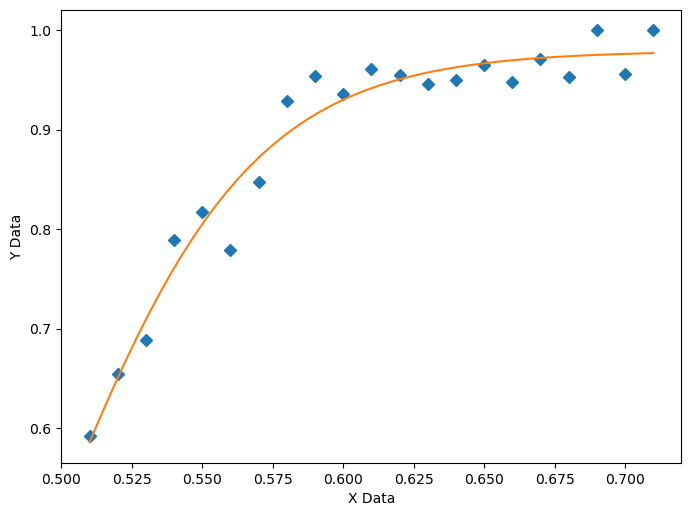

In [20]:
xgop = bm_gop.metric
ygop = bm_gop.is_GOP

def func(x, a, b, Offset): # Sigmoid A With Offset from zunzun.com
    return  1.0 / (1.0 + np.exp(-a * (x-b))) + Offset


# function for genetic algorithm to minimize (sum of squared error)
def sumOfSquaredError(parameterTuple):
    warnings.filterwarnings("ignore") # do not print warnings by genetic algorithm
    val = func(xgop, *parameterTuple)
    return np.sum((ygop - val) ** 2.0)


def generate_Initial_Parameters():
    # min and max used for bounds
    maxX = max(xgop)
    minX = min(xgop)
    maxY = max(ygop)
    minY = min(ygop)

    parameterBounds = []
    parameterBounds.append([minX, maxX]) # search bounds for a
    parameterBounds.append([minX, maxX]) # search bounds for b
    parameterBounds.append([0.0, maxY]) # search bounds for Offset

    # "seed" the np random number generator for repeatable results
    result = differential_evolution(sumOfSquaredError, parameterBounds, seed=3)
    return result.x

# generate initial parameter values
geneticParameters = generate_Initial_Parameters()

# curve fit the test data
fittedParameters, pcov = curve_fit(func, xgop, ygop, geneticParameters)

print('Parameters', fittedParameters)

modelPredictions = func(xgop, *fittedParameters) 

absError = modelPredictions - ygop

SE = np.square(absError) # squared errors
MSE = np.mean(SE) # mean squared errors
RMSE = np.sqrt(MSE) # Root Mean Squared Error, RMSE
Rsquared = 1.0 - (np.var(absError) / np.var(ygop))
print('RMSE:', RMSE)
print('R-squared:', Rsquared)

mpg = pd.DataFrame(modelPredictions)

def ModelAndScatterPlot(graphWidth, graphHeight):
    f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=100)
    axes = f.add_subplot(111)

    # first the raw data as a scatter plot
    axes.plot(xgop, ygop,  'D')

    # create data for the fitted equation plot
    xModel = np.linspace(min(xgop), max(xgop))
    yModel = func(xModel, *fittedParameters)

    # now the model as a line plot 
    axes.plot(xModel, yModel)

    axes.set_xlabel('X Data') # X axis data label
    axes.set_ylabel('Y Data') # Y axis data label

    plt.show()
    plt.close('all') # clean up after using pyplot

graphWidth = 800
graphHeight = 600
ModelAndScatterPlot(graphWidth, graphHeight)

In [21]:
mpd.head

<bound method NDFrame.head of       metric
0  -0.002226
1  -0.002226
2  -0.002226
3  -0.002226
4  -0.002226
5  -0.002226
6  -0.002226
7  -0.002225
8  -0.002224
9  -0.002224
10 -0.002222
11 -0.002220
12 -0.002218
13 -0.002214
14 -0.002208
15 -0.002201
16 -0.002189
17 -0.002173
18 -0.002150
19 -0.002117
20 -0.002071
21 -0.002003
22 -0.001907
23 -0.001770
24 -0.001574
25 -0.001293
26 -0.000892
27 -0.000319
28  0.000499
29  0.001667
30  0.003333
31  0.005707
32  0.009082
33  0.013869
34  0.020637
35  0.030157
36  0.043454
37  0.061851
38  0.086965
39  0.120629
40  0.164670
41  0.220491
42  0.288468
43  0.367327
44  0.453825>

### Compare

In [22]:
compare = bm
bm_split_probit = pd.concat([bm_dem_probit,bm_gop_probit]).reset_index(drop=True)
mp = pd.concat([mpd,mpg]).reset_index(drop=True)
compare["custom"] = mp
compare["probit"] = bm_split_probit[0]
compare.diff_prob = compare["is_GOP"] - compare["probit"]
compare.diff_cust = compare["is_GOP"] - compare["custom"]

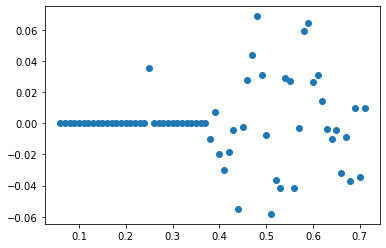

In [23]:
plt.scatter(compare.metric,compare.diff_prob)

This Scatterplot shows random, or at least more random, error than the previous models. Instead of a consistent "lambda" shape it is more scattered around the areas where prediction  is important

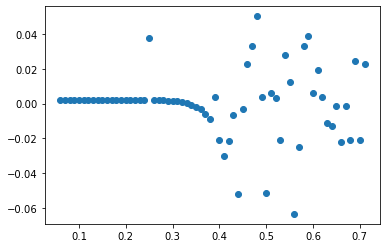

In [24]:
plt.scatter(compare.metric,compare.diff_cust)

In [25]:
compare

,metric,year,congress,is_GOP,custom,probit
0,0.06,2017.000000,115.500000,0.000000,-0.002226,0.00
1,0.07,2010.000000,112.000000,0.000000,-0.002226,0.00
2,0.08,2013.000000,113.500000,0.000000,-0.002226,0.00
3,0.09,2010.500000,112.250000,0.000000,-0.002226,0.00
4,0.10,2014.285714,114.142857,0.000000,-0.002226,0.00
5,0.11,2010.000000,112.000000,0.000000,-0.002226,0.00
6,0.12,2011.058824,112.529412,0.000000,-0.002226,0.00
7,0.13,2015.090909,114.545455,0.000000,-0.002225,0.00
8,0.14,2011.578947,112.789474,0.000000,-0.002224,0.00
9,0.15,2010.080000,112.040000,0.000000,-0.002224,0.00


From all of these models, we find that a custom fit is better than the alternative, but fails to address the "EVEN GAP" of the aforementioned data. Next, we will explore modelling that seeks to split the dataset along 51%+ and 50%- to account for the two halves of the model. 